In [46]:
import torch.nn as nn
import torch

mel_freq_bins = 128
time_steps = 89

class ConvModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, mel_freq_bins, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size of the flattened features
        self.flat_features = mel_freq_bins * (mel_freq_bins // 8) * (time_steps // 8)
        
        self.fc1 = nn.Linear(self.flat_features, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, 1, 128, 366)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.flat_features)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model
conv_model_loaded = ConvModel()
conv_model_loaded.load_state_dict(torch.load(f'model_weights/audrey_model_weights_2024-10-26.pth', map_location=device))



/var/folders/b1/c854wtzj2s12cmyl08yzghym0000gn/T/ipykernel_49264/3684203277.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_model_loaded.load_state_dict(torch.load

<All keys matched successfully>

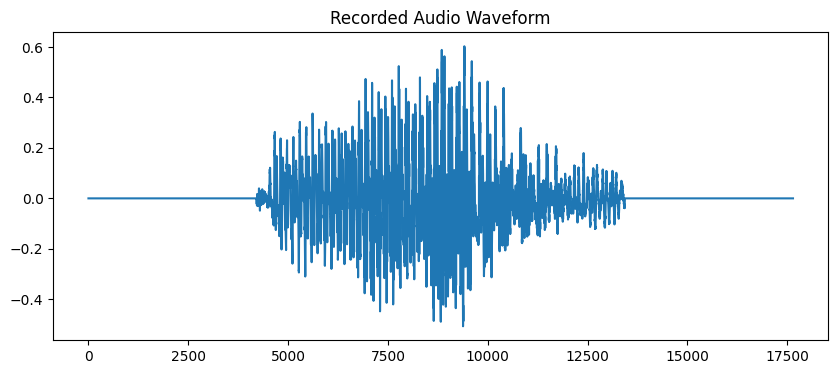

tensor([[ -1.8127, -22.6536,  22.4637,  47.7749,   4.6383, -36.4861,   1.5574,
         -27.4435,   3.5005, -25.1664]], grad_fn=<AddmmBackward0>)
Model prediction: 3


In [8]:
import sounddevice as sd
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import soundfile as sf
import librosa
import torch as t

# Get the length of the longest audio file
#longest_audio_file_length = max([torchaudio.info(f).num_frames for f in files])

longest_audio_file_length = 17647

audio, sample_rate = librosa.load('test.wav', sr=22050)

current_size = len(audio)
pad_size = longest_audio_file_length - current_size
left_pad = pad_size // 2
right_pad = pad_size - left_pad
padded_audio = np.pad(audio, (left_pad, right_pad), mode='constant')
sf.write('test_padded.wav', padded_audio, sample_rate)

audio, sample_rate = librosa.load('test_padded.wav', sr=22050)

plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Recorded Audio Waveform")
plt.show()

display(Audio(audio, rate=sample_rate))
audio = t.tensor([np.array(audio)])

# display spectrogram
spec = torchaudio.transforms.MelSpectrogram()(audio)

# Pass spec into model
outputs = conv_model_loaded(spec)

print(outputs)
# Print the prediction
print("Model prediction:", outputs.argmax().item())